# MRI Gibbs Artefacts removal

Magnectic Resonance (MR) images are reconstructed from measures of their Fourier expansion coefficients. Since in practive only a finite number of Fourier expansion coefficients can be acquired, reconstructed MR images are intrisically corrupted by gibbs artefacts which manifest by intensity oscilations adjacent to edges of different tissues tipes [1, 2]. Although this artifact has been poorly addressed in the last decates, recent studies showed that in the context of diffusion-weighted imaging this artifact significantly bias the diffusion estimates [3, 4].

In the notebook, I will illustrate how Gibbs Artefacts can be removed from MR images.

After starting with the main content of this notebook, lest first import the notebook's relevant python modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## How to simulate and indentify gibbs artefacts?

Before exploring the strategies to reduce the influence of gibbs artefacts, it is important to understand the artifact properties. For this, in this section an image of an phanton: 

<matplotlib.colorbar.Colorbar instance at 0x00000000063178C8>

C:\Users\Rafael\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


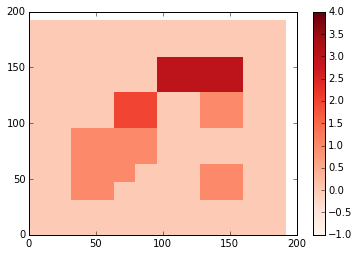

In [2]:
Nori = 32
image = np.zeros((6*Nori, 6*Nori))
image[Nori:2*Nori, Nori:2*Nori] = 1
image[3./2*Nori:2*Nori, 2*Nori:5./2*Nori] = 1
image[Nori:2*Nori, 4*Nori:5*Nori] = 1
image[2*Nori:3*Nori, Nori:3*Nori] = 1
image[3*Nori:4*Nori, 2*Nori:3*Nori] = 2
#image[3*Nori:4*Nori, 3*Nori:4*Nori] = np.linspace(31./16, 1./16, num=32)
image[3*Nori:4*Nori, 4*Nori:5*Nori] = 1
image[4*Nori:5*Nori, 3*Nori:5*Nori] = 3

plt.pcolormesh(image, cmap='Reds', vmin=-1, vmax=4)
plt.colorbar()

Gibbs artefact can be simulated on the above image by removing the Fourier coefficient expansion associated to the high frequencies of an image. Therefore, the descrite fourier transformation of this image photom is computed and illustrated below:

<matplotlib.colorbar.Colorbar instance at 0x00000000075F01C8>

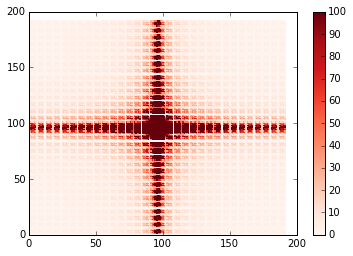

In [3]:
c = np.fft.fft2(image)
c = np.fft.fftshift(c)
plt.pcolormesh(abs(c), cmap='Reds', vmin=0, vmax=100)
plt.colorbar()

If the phanton reconstructed from only the middle half fourier transform coefficients is showed bellow. One can note that for this phanton the gibbs oscilation produce a grid like artefact.

192
96


<matplotlib.colorbar.Colorbar instance at 0x0000000007C5DF48>

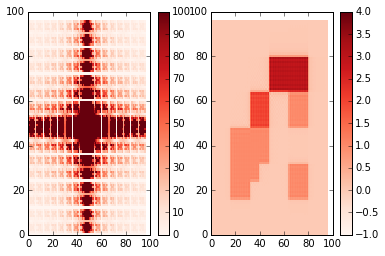

In [4]:
N = c.shape[0]
print N
c_crop = c[N*0.25: N*0.75, N*0.25: N*0.75]
N = c_crop.shape[0]
print N

plt.subplot(1, 2, 1)
plt.pcolormesh(abs(c_crop), cmap='Reds', vmin=0, vmax=100)
plt.colorbar()

plt.subplot(1, 2, 2)
image_gibbs = abs(np.fft.ifft2(c_crop)/4)
plt.pcolormesh(image_gibbs, cmap='Reds', vmin=-1, vmax=4)
plt.colorbar()

To note that, since reconstructed from only half of the number of Fourier coefficient, the gibbs corrupted image will also have wrost resolution. Thus, to have a ground truth image for the gibbs artefact removal algorithm, below a ground truth image is produced with the same resolution than the simulated gibbs corrupted image.

<matplotlib.colorbar.Colorbar instance at 0x00000000082CC5C8>

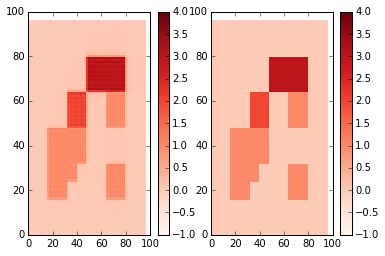

In [5]:
Nre = 16
image_gt = np.zeros((6*Nre, 6*Nre))
image_gt[Nre:2*Nre, Nre:2*Nre] = 1
image_gt[3./2*Nre:2*Nre, 2*Nre:5./2*Nre] = 1
image_gt[Nre:2*Nre, 4*Nre:5*Nre] = 1
image_gt[2*Nre:3*Nre, Nre:3*Nre] = 1
image_gt[3*Nre:4*Nre, 2*Nre:3*Nre] = 2
#image_gt[3*Nre:4*Nre, 3*Nre:4*Nre] = np.linspace(30./16, 2./16, num=16)
image_gt[3*Nre:4*Nre, 4*Nre:5*Nre] = 1
image_gt[4*Nre:5*Nre, 3*Nre:5*Nre] = 3

plt.subplot(1, 2, 1)
plt.pcolormesh(image_gibbs, cmap='Reds', vmin=-1, vmax=4)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(image_gt, cmap='Reds', vmin=-1, vmax=4)
plt.colorbar()

Section summary:

1) Gibbs artefacts can be simulated for any pre-processed image by excluding Fourier expansion coefficients (note that this will also induce an increase of image resolution).
2) Gibbs artefacts can be visualized as intensity oscilations near to image edges.

## How to deal with Gibbs artefacts?

The standard way to correct gibbs is to use the Lanczos filter, however this has the expense of image bluring. More recently, 

Gibbs artefacts can also be corrected using...

### Shift as proposed by Kellner and colleagues

Correction is first done line by line

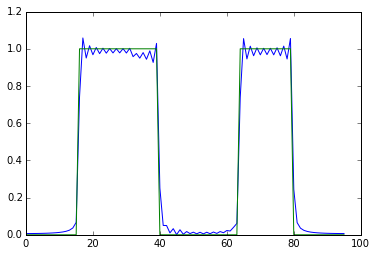

In [6]:
i = 26
plt.plot(image_gibbs[i])
plt.plot(image_gt[i])
plt.show()

c = np.fft.fft(image_gibbs[i])

This is what the article suggests to do

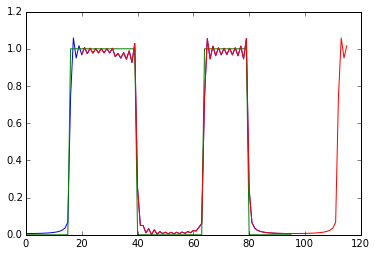

In [7]:
# adding an inter shift
N = c.shape[0]
k = np.arange(N)
s = 20
shift1 = np.exp(2j*np.pi*k*s / N)
I_s1 = np.fft.ifft(shift1 * c)
k1 = k + s

plt.plot(image_gibbs[i])
plt.plot(image_gt[i])
plt.plot(k1, abs(I_s1))
plt.show()

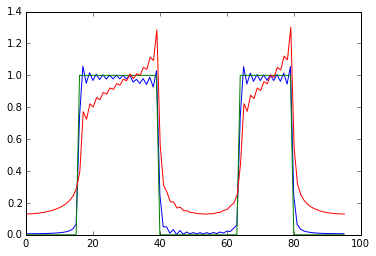

In [8]:
# adding an decimal shifts
N = c.shape[0]
k = np.arange(N)
k0 = k.copy();
I_s0 = np.fft.ifft(c)

s = 0.1
shift1 = np.exp(2j*np.pi*k*s / N)
I_s1 = np.fft.ifft(shift1 * c)
k1 = k + s

plt.plot(image_gibbs[i])
plt.plot(image_gt[i])
plt.plot(k1, abs(I_s1))
plt.show()

### Shift directly in spatial dimentions

In [9]:
def image_shift(x, s, a=0):
    """ Shift elements of matrix x by a position difference s
    along axis a.
    
    Parameters
    ----------
    x : 2D ndarray
        Original values of matrix x
    s : float
        Value of the shift
    a : int (0 or 1)
        Axis along which the shift will be applied.
        Default a is set to 0.
    
    Returns
    -------
    Shifted version of matrix x.
    
    Note
    ----
    The values of the new shifted matrix are calculated using
    linear interpolation of the values of the original matrix
    """
    if a:
        xs = x.copy()
    else:
        xs = x.T.copy()

    if s >= 1 or s <=-1:
        raise ValueError('Shift should be a value between -1 and 1')
    elif s > 0:
        xs[:, :-1] = (xs[:, 1:] - xs[:, :-1]) * s + xs[:, :-1]   
    else:
        xs[:, 1:] = (xs[:, 1:] - xs[:, :-1]) * (1+s) + xs[:, :-1]
    
    if a:
        return xs
    else:
        return xs.T

In [10]:
# test function
# for the following parameters
xtest = np.array([[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 3.0, 6.0, 5.0, 6.0, 5.0, 6.0],
                  [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 3.0, 6.0, 5.0, 6.0, 5.0, 6.0]])
s = 0.5
# we expext
xexpected = np.array([[0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 4.5, 5.5, 5.5, 5.5, 5.5, 6.0],
                      [0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 4.5, 5.5, 5.5, 5.5, 5.5, 6.0]])
x = image_shift(xtest, s, a=1)
print x

# Test axis 0
x = image_shift(xtest.T, s, a=0)
print x.T 

[[ 0.5  0.5  0.5  0.5  0.5  1.5  4.5  5.5  5.5  5.5  5.5  6. ]
 [ 0.5  0.5  0.5  0.5  0.5  1.5  4.5  5.5  5.5  5.5  5.5  6. ]]
[[ 0.5  0.5  0.5  0.5  0.5  1.5  4.5  5.5  5.5  5.5  5.5  6. ]
 [ 0.5  0.5  0.5  0.5  0.5  1.5  4.5  5.5  5.5  5.5  5.5  6. ]]


In [11]:
# second test
# for the following parameters
xtest = np.array([[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 3.0, 6.0, 5.0, 6.0, 5.0, 6.0],
                  [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 3.0, 6.0, 5.0, 6.0, 5.0, 6.0]])
s = 0.25
# we expext
xexpected = np.array([[0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 3.75, 5.75, 5.25, 5.75, 5.25, 6.0],
                      [0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 3.75, 5.75, 5.25, 5.75, 5.25, 6.0]])
x = image_shift(xtest, s, a=1)
print x

# Test axis 0
x = image_shift(xtest.T, s, a=0)
print x.T 

[[ 0.75  0.25  0.75  0.25  0.75  0.75  3.75  5.75  5.25  5.75  5.25  6.  ]
 [ 0.75  0.25  0.75  0.25  0.75  0.75  3.75  5.75  5.25  5.75  5.25  6.  ]]
[[ 0.75  0.25  0.75  0.25  0.75  0.75  3.75  5.75  5.25  5.75  5.25  6.  ]
 [ 0.75  0.25  0.75  0.25  0.75  0.75  3.75  5.75  5.25  5.75  5.25  6.  ]]


In [12]:
# for the following parameters
xtest = np.array([[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 3.0, 6.0, 5.0, 6.0, 5.0, 6.0],
                  [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 3.0, 6.0, 5.0, 6.0, 5.0, 6.0]])
s = -0.5
# we expext
xexpected = np.array([[1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 4.5, 5.5, 5.5, 5.5, 5.5],
                      [1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 4.5, 5.5, 5.5, 5.5, 5.5]])
print image_shift(xtest, s, a=1)

[[ 1.   0.5  0.5  0.5  0.5  0.5  1.5  4.5  5.5  5.5  5.5  5.5]
 [ 1.   0.5  0.5  0.5  0.5  0.5  1.5  4.5  5.5  5.5  5.5  5.5]]


In [13]:
# last test
# for the following parameters
xtest = np.array([[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 3.0, 6.0, 5.0, 6.0, 5.0, 6.0],
                  [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 3.0, 6.0, 5.0, 6.0, 5.0, 6.0]])
s = -0.25
# we expext
xexpected = np.array([[1., 0.25, 0.75, 0.25, 0.75, 0.25, 2.25, 5.25, 5.25, 5.75, 5.25, 5.75],
                      [1., 0.25, 0.75, 0.25, 0.75, 0.25, 2.25, 5.25, 5.25, 5.75, 5.25, 5.75]])
x = image_shift(xtest, s, a=1)
print x

# Test axis 0
x = image_shift(xtest.T, s, a=0)
print x.T 

[[ 1.    0.25  0.75  0.25  0.75  0.25  2.25  5.25  5.25  5.75  5.25  5.75]
 [ 1.    0.25  0.75  0.25  0.75  0.25  2.25  5.25  5.25  5.75  5.25  5.75]]
[[ 1.    0.25  0.75  0.25  0.75  0.25  2.25  5.25  5.25  5.75  5.25  5.75]
 [ 1.    0.25  0.75  0.25  0.75  0.25  2.25  5.25  5.25  5.75  5.25  5.75]]


Lets do this know in our simulations

In [14]:
# adding shifts
N = c.shape[0]
x = np.arange(N)
x0 = x.copy();
s = 0
I_s0 = image_shift(image_gibbs, s, a=1)

s = -0.8
I_s1 = image_shift(image_gibbs, s, a=1)
x1 = x + s

s = -0.6
I_s2 = image_shift(image_gibbs, s, a=1)
x2 = x + s

s = -0.4
I_s3 = image_shift(image_gibbs, s, a=1)
x3 = x + s

s = -0.2
I_s4 = image_shift(image_gibbs, s, a=1)
x4 = x + s

s = 0.2
I_s5 = image_shift(image_gibbs, s, a=1)
x5 = x + s

s = 0.4
I_s6 = image_shift(image_gibbs, s, a=1)
x6 = x + s

s = 0.6
I_s7 = image_shift(image_gibbs, s, a=1)
x7 = x + s

s = 0.8
I_s8 = image_shift(image_gibbs, s, a=1)
x8 = x + s

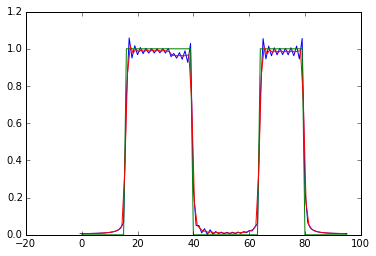

In [15]:
plt.plot(image_gibbs[i])
plt.plot(image_gt[i])
plt.plot(x2, abs(I_s2[i]))
plt.show()

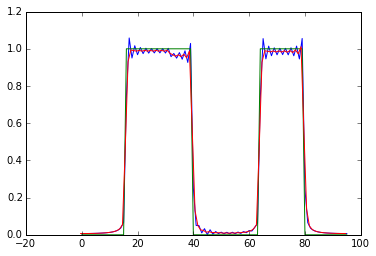

In [16]:
plt.plot(image_gibbs[i])
plt.plot(image_gt[i])
plt.plot(x3, abs(I_s3[i]))
plt.show()

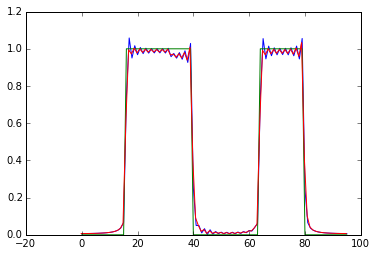

In [17]:
plt.plot(image_gibbs[i])
plt.plot(image_gt[i])
plt.plot(x4, abs(I_s4[i]))
plt.show()

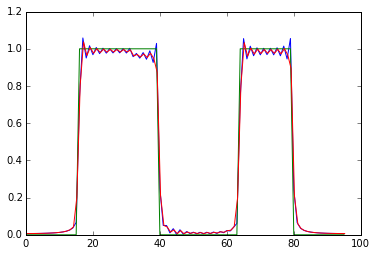

In [18]:
plt.plot(image_gibbs[i])
plt.plot(image_gt[i])
plt.plot(x5, abs(I_s5[i]))
plt.show()

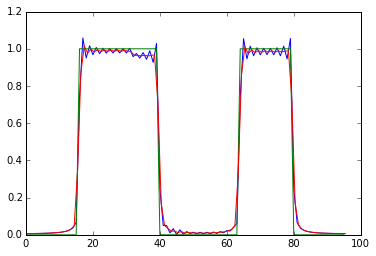

In [19]:
plt.plot(image_gibbs[i])
plt.plot(image_gt[i])
plt.plot(x6, abs(I_s6[i]))
plt.show()

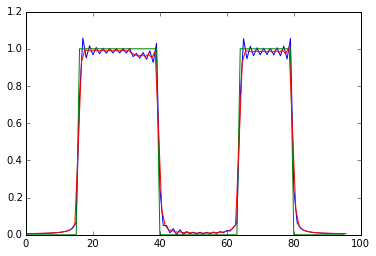

In [20]:
plt.plot(image_gibbs[i])
plt.plot(image_gt[i])
plt.plot(x7, abs(I_s7[i]))
plt.show()

### Find total variance (TV) of time series

In [21]:
def image_tv(x, fn=0, nn=3, a=0):
    """ Computes total variation (TV) of matrix x along axis a
    in two directions.
    
    Parameters
    ----------
    x : 2D ndarray
        matrix x 
    fn : int
        Distance of first neighbor to be included in TV calculation
        If fn=0 the own point is also included in the TV calculation
    nn : int
        Number of points to be included in TV calculation
    a : int (0 or 1)
        Axis along which TV will be calculated.
        Default a is set to 0.
    
    Returns
    -------
    PTV : 2D ndarray
        Total variation calculated from the right neighbors of each
        point
    NTV : 2D ndarray
        Total variation calculated from the left neighbors of each
        point

    Note
    ----
    This function was created to deal with gibbs artefacts of MR images.
    Assuming that MR images are reconstructed from estimates of their
    Fourier expansion coefficients, during TV calculation matrix x can
    taken as and periodic signal. In this way NTV values on the image
    left boundary is computed using the time series values on the right
    boundary and vice versa.
    """
    if a:
        xs = x.copy()
    else:
        xs = x.T.copy()

    xs = np.concatenate((xs[:, (-nn-fn):], xs, xs[:, 0:(nn+fn)]), axis=1)

    PTV = np.absolute(xs[:, (nn+fn):(-nn-fn)] - xs[:, (nn+fn+1):(-nn-fn+1)])
    NTV = np.absolute(xs[:, (nn+fn):(-nn-fn)] - xs[:, (nn+fn-1):(-nn-fn-1)])
    for n in np.linspace(fn+1, nn-2, num=nn-2):
        PTV = PTV + np.absolute(xs[:, (nn+fn+n):(-nn-fn+n)] - xs[:, (nn+fn+n+1):(-nn-fn+n+1)])
        NTV = NTV + np.absolute(xs[:, (nn+fn-n):(-nn-fn-n)] - xs[:, (nn+fn-n-1):(-nn-fn-n-1)])
    
    if a:
        return PTV, NTV
    else:
        return PTV.T, NTV.T

Testing function line by line

In [22]:
# give some inputs to test
nn = 3
fn = 0
# Add extreme neighbors assuming that data is periodic
x = image_gibbs
xs = x.copy()
xs = np.concatenate((xs[:, (-nn-fn):], xs, xs[:, 0:(nn+fn)]), axis=1)

(96L, 96L)
(96L, 102L)


array([  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.])

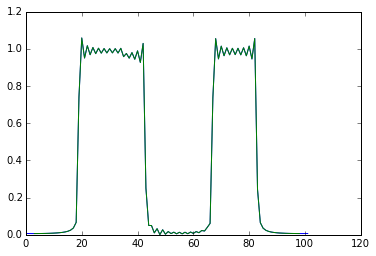

In [23]:
# Check outputs
print x.shape
print xs.shape
plt.plot(xs[i])
plt.plot(np.linspace(3, 98, num=96), image_gibbs[i])
np.linspace(3, 98, num=96)

In [24]:
# test the TV core lines
PTV = np.absolute(xs[:, (nn+fn):(-nn-fn)] - xs[:, (nn+fn+1):(-nn-fn+1)])
NTV = np.absolute(xs[:, (nn+fn):(-nn-fn)] - xs[:, (nn+fn-1):(-nn-fn-1)])
for n in np.linspace(fn+1, nn-2, num=nn-2):
    PTV = PTV + np.absolute(xs[:, (nn+fn+n):(-nn-fn+n)] - xs[:, (nn+fn+n+1):(-nn-fn+n+1)])
    NTV = NTV + np.absolute(xs[:, (nn+fn-n):(-nn-fn-n)] - xs[:, (nn+fn-n-1):(-nn-fn-n-1)])

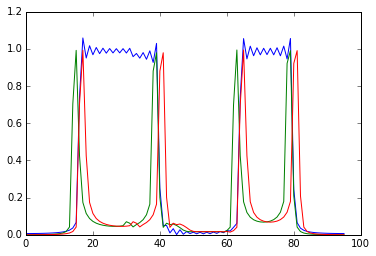

In [25]:
# check if TV values make sense
plt.plot(image_gibbs[i])
plt.plot(PTV[i])
plt.plot(NTV[i])

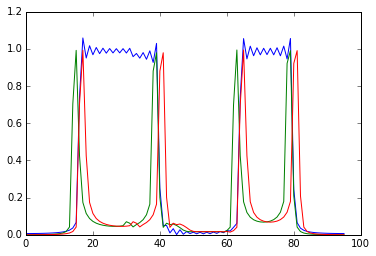

In [26]:
# check TV function
TVp, TVn = image_tv(image_gibbs, fn=0, nn=3, a=1)
plt.plot(image_gibbs[i])
plt.plot(TVp[i])
plt.plot(TVn[i])

<matplotlib.colorbar.Colorbar instance at 0x000000000837EA48>

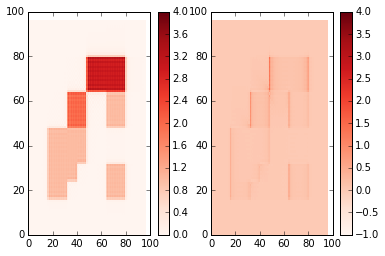

In [27]:
plt.subplot(1, 2, 1)
plt.pcolormesh(image_gibbs, cmap='Reds', vmin=0, vmax=4)
plt.colorbar()

TV = np.minimum(TVp, TVn)

plt.subplot(1, 2, 2)
plt.pcolormesh(TV, cmap='Reds', vmin=-1, vmax=4)
plt.colorbar()

### TV in shifted data - what values of shift should be covered?

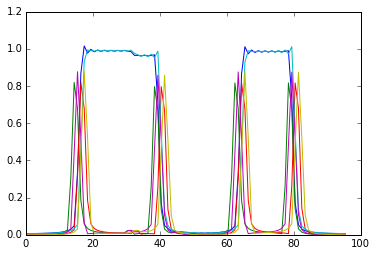

In [28]:
x = np.arange(N)
s = 0.4
I_s1 = image_shift(image_gibbs, s, a=1)
TVp, TVn = image_tv(I_s1, fn=0, nn=3, a=1)
x1 = x + s
plt.plot(x1, I_s1[i])
plt.plot(x1, TVp[i])
plt.plot(x1, TVn[i])

s2 = -0.4
I_s2 = image_shift(image_gibbs, s2, a=1)
TVp2, TVn2 = image_tv(I_s2, fn=0, nn=3, a=1)
x2 = x + s
plt.plot(x2, I_s2[i])
plt.plot(x2, TVp2[i])
plt.plot(x2, TVn2[i])

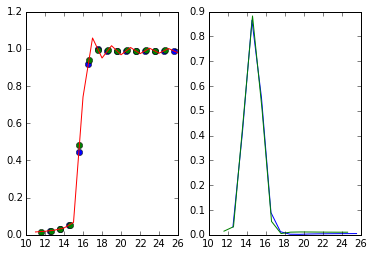

In [29]:
x = np.arange(N)

s = 0.56
I_s1 = image_shift(image_gibbs, s, a=1)
TVp1, TVn1 = image_tv(I_s1, fn=0, nn=3, a=1)
x1 = x + s

s = -0.38
I_s2 = image_shift(image_gibbs, s, a=1)
TVp2, TVn2 = image_tv(I_s2, fn=0, nn=3, a=1)
x2 = x + s

plt.subplot(1, 2, 1)
plt.plot(x1[12:26], I_s1[i, 12:26], 'o')
plt.plot(x2[12:26], I_s2[i, 12:26], 'o')
plt.plot(x[11:27], image_gibbs[i, 11:27], '-')

plt.subplot(1, 2, 2)
plt.plot(x1[12:26], TVp1[i, 12:26])
plt.plot(x2[12:26], TVp2[i, 12:26])

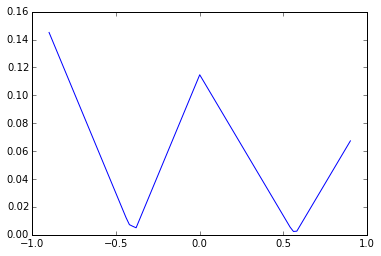

In [30]:
ssamp = np.linspace(-0.9, 0.9, num=91)

TVP18 = np.zeros(ssamp.shape)
idx = 0;
for s in ssamp:
    shift = image_shift(image_gibbs, s, a=1)
    TVp1, TVn1 = image_tv(shift, fn=0, nn=3, a=1)
    TVP18[idx] = TVp1[i, 18]
    idx = idx + 1

plt.plot(ssamp, TVP18)

In [31]:
np.array([ssamp, TVP18]).T

array([[-0.9       ,  0.14504161],
       [-0.88      ,  0.13926944],
       [-0.86      ,  0.13349727],
       [-0.84      ,  0.12772511],
       [-0.82      ,  0.12195294],
       [-0.8       ,  0.11618077],
       [-0.78      ,  0.11040861],
       [-0.76      ,  0.10463644],
       [-0.74      ,  0.09886427],
       [-0.72      ,  0.0930921 ],
       [-0.7       ,  0.08731994],
       [-0.68      ,  0.08154777],
       [-0.66      ,  0.0757756 ],
       [-0.64      ,  0.07000343],
       [-0.62      ,  0.06423127],
       [-0.6       ,  0.0584591 ],
       [-0.58      ,  0.05268693],
       [-0.56      ,  0.04691477],
       [-0.54      ,  0.0411426 ],
       [-0.52      ,  0.03537043],
       [-0.5       ,  0.02959826],
       [-0.48      ,  0.0238261 ],
       [-0.46      ,  0.01805393],
       [-0.44      ,  0.01228176],
       [-0.42      ,  0.00727461],
       [-0.4       ,  0.00609068],
       [-0.38      ,  0.00503474],
       [-0.36      ,  0.01080691],
       [-0.34      ,

After repeating this analysis to other points, it seems that optimal shifts are around -0.5 and 0.5. However for cases near edges, the desired shifts could be different (e.g. -0.24 and 0.76 for point 16). In this way, in my gibbs correction algorithm I will access all shift values between -0.9 and 0.9.

## What should be the value of the corrected itensity?

From the analysis in previous section, one can see that there is normally a minimum TV value for both negative and positive shifts. Therefore, a way to obtain the corrected intensity is by first finding both negative and positive shifts with smaller TV (positive or negative), and then using them to interpolate the corrected intensity.

Following this, lets find the negative and positive shifts with minimal TV for each data point. For the interpolation, in addition to the shifts values with minima TV (called here SP and SN), their amplitudes are also required (called here ISP, ISN).

In [32]:
ssamp = np.linspace(0.02, 0.9, num=45)

TVR, TVL = image_tv(image_gibbs, fn=0, nn=3, a=1)
TVP = np.minimum(TVR, TVL)
TVN = TVP.copy()
ISP = image_gibbs.copy()
ISN = image_gibbs.copy()
SP = np.zeros(image_gibbs.shape)
SN = np.zeros(image_gibbs.shape)
for s in ssamp:
    Img_p = image_shift(image_gibbs, s, a=1)
    Img_n = image_shift(image_gibbs, -s, a=1)
    TVSR, TVSL = image_tv(Img_p, fn=0, nn=3, a=1)
    TVS_p = np.minimum(TVSR, TVSL)
    TVSR, TVSL = image_tv(Img_n, fn=0, nn=3, a=1)
    TVS_n = np.minimum(TVSR, TVSL)
    update_pos_ind = TVP > TVS_p
    update_neg_ind = TVN > TVS_n
    TVP[update_pos_ind] = TVS_p[update_pos_ind]
    TVN[update_neg_ind] = TVS_n[update_neg_ind]
    ISP[update_pos_ind] = Img_p[update_pos_ind]
    ISN[update_neg_ind] = Img_n[update_neg_ind]
    SP[update_pos_ind] = s
    SN[update_neg_ind] = s

<matplotlib.colorbar.Colorbar instance at 0x000000000A7BA608>

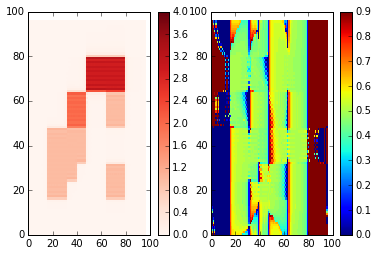

In [33]:
plt.subplot(1, 2, 1)
plt.pcolormesh(ISP, cmap='Reds', vmin=0, vmax=4)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(SP)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x000000000AE4F348>

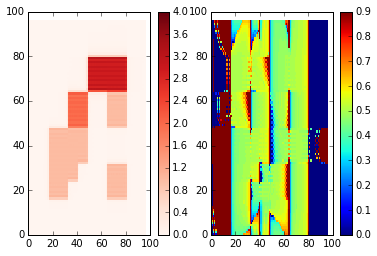

In [34]:
plt.subplot(1, 2, 1)
plt.pcolormesh(ISN, cmap='Reds', vmin=0, vmax=4)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(SN)
plt.colorbar()

Now that we have SP, SN, ISP, and ISN we can compute the gibbs corrected image as:

In [35]:
# no correction is necessary if SP and/or SN is zero
idx = np.nonzero(SP + SN)
img_cx = image_gibbs.copy()
img_cx[idx] = (ISP[idx] - ISN[idx])/(SP[idx] + SN[idx])*SN[idx] + ISN[idx]

<matplotlib.colorbar.Colorbar instance at 0x000000000B4A8EC8>

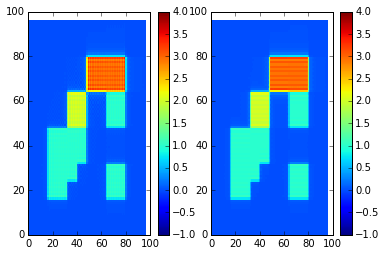

In [36]:
plt.subplot(1, 2, 1)
plt.pcolormesh(image_gibbs, vmin=-1, vmax=4)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(img_cx, vmin=-1, vmax=4)
plt.colorbar()

Results show that gibbs oscilations are decreased along the x directions. To correct the oscilation along the y direction the same procedure can be used along the y axis.

Let them define a function will all the steps above:

In [37]:
def gibbs_removal_1d(x, a=0, fn=0, nn=3):
    """ Decreases gibbs ringing along axis a
    
    Parameters
    ----------
    x : 2D ndarray
        Matrix x
    a : int (0 or 1)
        Axis along which gibbs oscilations will be reduced.
        Default a is set to 0 (i.e. gibbs are reduce along axis
        y).
    fn : int, optional
        Distance of first neighbour used to access local TV (see
        note). Defaults is set to 0 which means that the own point
        is also used to access local TV.
    nn : int, optional
        Number of neighbour points to access local TV (see note).
        Default is set to 3
    
    Returns
    -------
    xc : 2D ndarray
        Matrix with gibbs oscilantions reduced along axis a
    tv : 2D ndarray
        Global TV which show variation not removed (edges,
        anatomical variation, non-oscilatory component of gibbs
        artefact of background, etc.)

    Note
    ----
    This function decreases the effects of gibbs oscilations based
    on the analysis of local total variation (TV). Although
    correction is done based on two adjanced points for each voxel,
    total variation is accessed in a larger range of neigbors. To
    adjust the neigbors that the function used adjust parameters fn
    and nn.
    """
    ssamp = np.linspace(0.02, 0.9, num=45)

    # TV for shift zero (baseline)
    TVR, TVL = image_tv(image_gibbs, fn=fn, nn=nn, a=a)
    TVP = np.minimum(TVR, TVL)
    TVN = TVP.copy()
    
    # Find optimal shift for gibbs removal
    ISP = image_gibbs.copy()
    ISN = image_gibbs.copy()
    SP = np.zeros(image_gibbs.shape)
    SN = np.zeros(image_gibbs.shape)
    for s in ssamp:
        # Image shift using current pos shift
        Img_p = image_shift(image_gibbs, s, a=a)
        TVSR, TVSL = image_tv(Img_p, fn=fn, nn=nn, a=a)
        TVS_p = np.minimum(TVSR, TVSL)
        # Image shift using current neg shift
        Img_n = image_shift(image_gibbs, -s, a=a)
        TVSR, TVSL = image_tv(Img_n, fn=fn, nn=nn, a=a)
        TVS_n = np.minimum(TVSR, TVSL)
        # Update positive shift params
        ISP[TVP > TVS_p] = Img_p[TVP > TVS_p]
        SP[TVP > TVS_p] = s
        TVP[TVP > TVS_p] = TVS_p[TVP > TVS_p]
        # Update negative shift params
        ISN[TVN > TVS_n] = Img_n[TVN > TVS_n]
        SN[TVN > TVS_n] = s
        TVN[TVN > TVS_n] = TVS_n[TVN > TVS_n]

    # apply correction if SP and SN are not zeros
    idx = np.nonzero(SP + SN)
    xc = image_gibbs.copy()
    xc[idx] = (ISP[idx] - ISN[idx])/(SP[idx] + SN[idx])*SN[idx] + ISN[idx]

    # Global minimum TV (can be useful as edge detector)
    TV = np.minimum(TVN, TVP)

    return xc, TV

<matplotlib.colorbar.Colorbar instance at 0x000000000E742108>

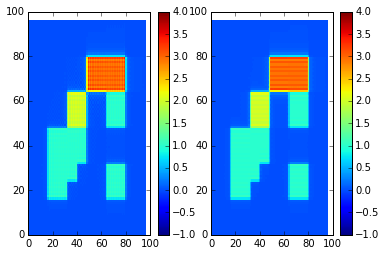

In [46]:
# To test the function above
plt.subplot(1, 2, 1)
plt.pcolormesh(image_gibbs, vmin=-1, vmax=4)
plt.colorbar()

img_cx, tv_cx =  gibbs_removal_1d(x, a=1, fn=0, nn=3)

plt.subplot(1, 2, 2)
plt.pcolormesh(img_cx2, vmin=-1, vmax=4)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x0000000010554E08>

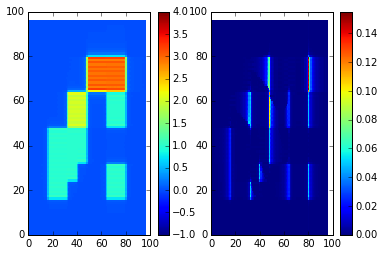

In [49]:
# see edges
plt.subplot(1, 2, 1)
plt.pcolormesh(img_cx, vmin=-1, vmax=4)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(tv_cx)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x0000000010CC2E88>

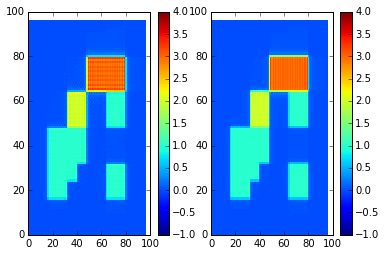

In [50]:
# apply correction along axis y
plt.subplot(1, 2, 1)
plt.pcolormesh(image_gibbs, vmin=-1, vmax=4)
plt.colorbar()

img_cy, tv_cy =  gibbs_removal_1d(x, a=0, fn=0, nn=3)

plt.subplot(1, 2, 2)
plt.pcolormesh(img_cy, vmin=-1, vmax=4)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x00000000112F8108>

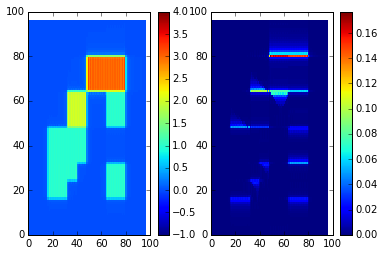

In [51]:
# see edges
plt.subplot(1, 2, 1)
plt.pcolormesh(img_cy, vmin=-1, vmax=4)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(tv_cy)
plt.colorbar()

## Combining correction along two directions

Now that we have the correction along the two directions, the 2D gibbs correction can be obtain as [5]:

$$ IC = FT^{-1}  [FT(J_x)\times G_x + FT(J_y)\times G_y] $$

where $J_x$ and $J_y$ are the images corrected along axis x and y, while $G_x$ and $G_y$ are the weighting functions:

$$ G_x = \frac{1 + \cos k_y}{(1 + \cos k_y)+(1 + \cos k_x)} $$

and 

$$ G_y = \frac{1 + \cos k_x}{(1 + \cos k_y)+(1 + \cos k_x)} $$ 

Let first start by defining the weighting functions:

In [52]:
def _gibbs_removal_2d_weigthing_funcs(shape):
    """ Computes the weighting functions to combine two
    images processed by the 1D gibbs removal procedure
    along two different axis [1]_.
    
    Parameters
    ----------
    shape : tuple
        shape of the image

    Returns
    -------
    Gx : 2D ndarray
        values of the weighting function Gx [1]_.
        
    Gy : 2D ndarray
        values of the weighting function Gy [1]_.

    References
    ----------
    .. [1] Kellner E, Dhital B, Kiselev VG, Reisert M.
    Gibbs-ringing artifact removal based on local subvoxel-
    shifts. Magn Reson Med. 2015 doi: 10.1002/mrm.26054.
    """
    Gx = np.zeros(shape)
    Gy = np.zeros(shape)
    ky = np.linspace(-np.pi, np.pi, num=shape[0])
    kx = np.linspace(-np.pi, np.pi, num=shape[1])

    # Middle points
    KX, KY = np.meshgrid(kx[1:-1], ky[1:-1])
    cosky = 1.0 + np.cos(KY) 
    coskx = 1.0 + np.cos(KX)
    Gx[1:-1, 1:-1] = cosky / (cosky+coskx)
    Gy[1:-1, 1:-1] = coskx / (cosky+coskx)

    # Boundaries
    Gx[1:-1, 0] = Gx[1:-1, -1] = 1
    Gx[0, 0] = Gx[-1, -1] = Gx[0, -1] = Gx[-1, 0] = 1/2
    Gy[0, 1:-1] = Gy[-1, 1:-1] = 1
    Gy[0, 0] = Gy[-1, -1] = Gy[0, -1] = Gx[-1, 0] = 1/2

    return Gx, Gy

<matplotlib.colorbar.Colorbar instance at 0x000000001194F308>

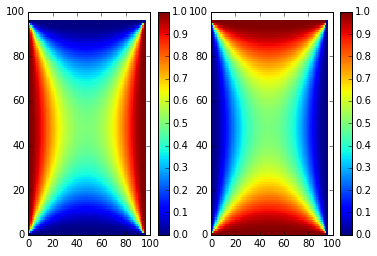

In [53]:
Gx, Gy = _gibbs_removal_2d_weigthing_funcs(image_gibbs.shape)

# see weigthing function
plt.subplot(1, 2, 1)
plt.pcolormesh(Gx)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(Gy)
plt.colorbar()

Now we are ready to apply the final correction:

<matplotlib.colorbar.Colorbar instance at 0x00000000120BC488>

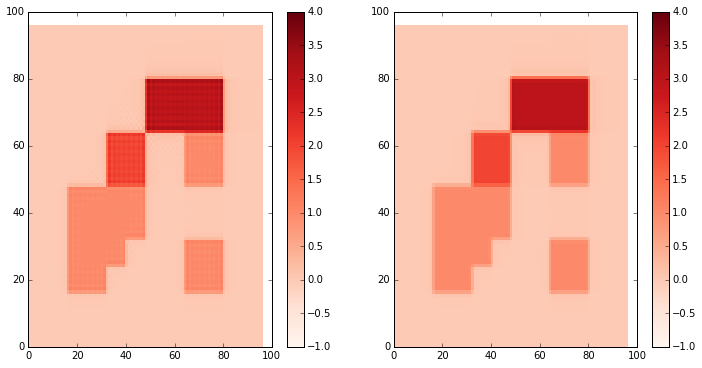

In [54]:
Cx = np.fft.fft2(img_cx)
Cy = np.fft.fft2(img_cy)
IC = np.fft.ifft2(np.fft.fftshift(Cx)*Gx + np.fft.fftshift(Cy)*Gy)

fig = plt.figure(figsize = (12, 6))
fig.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
plt.pcolormesh(image_gibbs, cmap='Reds', vmin=-1, vmax=4)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(abs(IC), cmap='Reds', vmin=-1, vmax=4)
plt.colorbar()

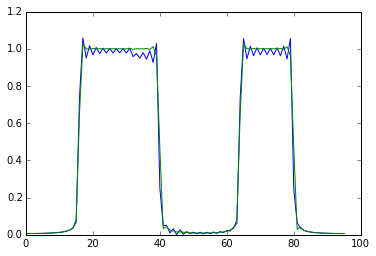

In [55]:
plt.plot(image_gibbs[i])
plt.plot(abs(IC[i]))

Lets analyse the residual TVs

<matplotlib.colorbar.Colorbar instance at 0x00000000148ED388>

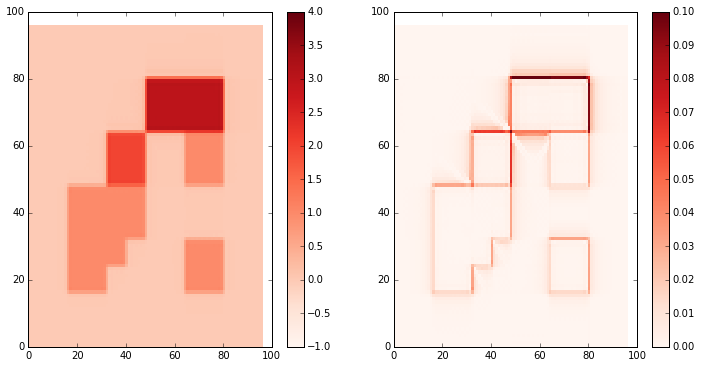

In [60]:
Tx = np.fft.fft2(tv_cx)
Ty = np.fft.fft2(tv_cy)
TV = np.fft.ifft2(np.fft.fftshift(Tx)*Gx + np.fft.fftshift(Ty)*Gy)

fig = plt.figure(figsize = (12, 6))
fig.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
plt.pcolormesh(abs(IC), cmap='Reds', vmin=-1, vmax=4)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(abs(TV), cmap='Reds', vmin=0, vmax=0.1)
plt.colorbar()

References:
1. Wilbraham H. On a certain periodic function. Camb Dubl Math J 1848;3:198–201.
2. Gibbs JW. Fourier’s series. Nature 1898;59:200.
3. Perrone D, Aelterman J, Pižurica A, Jeurissen B, Philips W, Leemans A. The effect of Gibbs ringing artifacts on measures derived from diffusion MRI. Neuroimage. 2015 Oct 15;120:441-55. doi: 10.1016/j.neuroimage.2015.06.068. 
4. Veraart J, Fieremans E, Jelescu IO, Knoll F, Novikov, DS. Gibbs Ringing in Diffusion MRI. Magn Reson Med. 2015 doi: 10.1002/mrm.25866
5. Kellner E, Dhital B, Kiselev VG, Reisert M. Gibbs-ringing artifact removal based on local subvoxel-shifts. Magn Reson Med. 2015 doi: 10.1002/mrm.26054.